# 3D MT forward modelling

## Learning goals

- Understand **spatial features** of six different components of the transfer function measured: Zxx, Zxy, Zyy, Zyx, Tzx, Tzy. 
- Identify general structure of SimPEG forward modelling.

In [1]:
import discretize
from simpeg.electromagnetics import natural_source as nsem
from simpeg import utils
import numpy as np
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['font.size'] = 16
import warnings
warnings.filterwarnings("ignore")

## Step 1: Discretize the domain using a 3D `Tensor` Mesh

In [2]:
# Make a mesh
hx = [(100, 9, -1.5), (100.0, 13), (100, 9, 1.5)]
hy = [(100, 9, -1.5), (100.0, 13), (100, 9, 1.5)]
hz = [(50, 10, -1.6), (50.0, 10), (50, 6, 2)]
hz = discretize.utils.mesh_utils.unpack_widths(hz)
mesh = discretize.TensorMesh(
    [hx, hy, hz],
    x0=["C", "C", -hz[:20].sum()],
)
# Setup the model
sig_block = 1
sig_background = 1e-2
conds = [sig_background, sig_block]
sig = utils.model_builder.create_block_in_wholespace(
    mesh.gridCC, [-100, -300, -350], [100, 300, -150], conds
)
sig[mesh.gridCC[:, 2] > 0] = 1e-8
sig[mesh.gridCC[:, 2] < -1000] = 1e-1
sigBG = np.ones(mesh.nC) * sig_background
sigBG[mesh.gridCC[:, 2] > 0] = 1e-8
block_x = np.r_[-100, 100, 100, -100, -100]
block_y = np.r_[-300, -300, 300, 300, -300]

Text(0.5, 1.0, '')

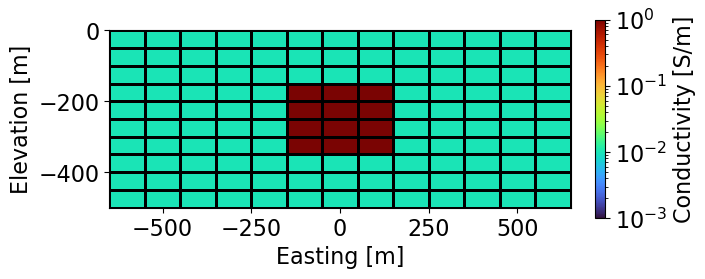

In [3]:
collect_obj = mesh.plotSlice(sig, grid=True, normal="Y", pcolor_opts={'norm': LogNorm(vmin=1e-3, vmax=1), 'cmap':'turbo'})[0]
cb = plt.colorbar(collect_obj, fraction=0.02)
cb.set_label("Conductivity [S/m]")
plt.xlim(-650, 650)
plt.ylim(-500, 0)
plt.gca().set_aspect(1)
plt.xlabel("Easting [m]")
plt.ylabel("Elevation [m]")
plt.title("")

Text(0.5, 1.0, '')

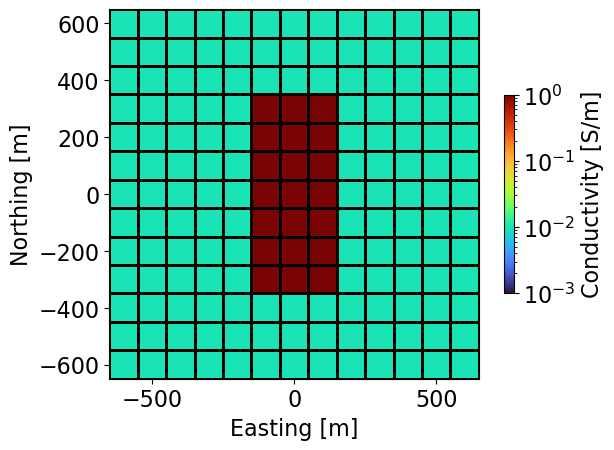

In [4]:
collect_obj = mesh.plotSlice(sig, grid=True, normal="Z", pcolor_opts={'norm': LogNorm(vmin=1e-3, vmax=1), 'cmap':'turbo'})[0]
cb = plt.colorbar(collect_obj, fraction=0.02)
plt.xlim(-650, 650)
plt.ylim(-650, 650)
plt.gca().set_aspect(1)
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
cb.set_label("Conductivity [S/m]")
plt.title("")

## Step 2: Setup a `Survey` 

In [5]:
# Setup the the survey object
# Receiver locations
rx_x, rx_y = np.meshgrid(np.arange(-600, 601, 100), np.arange(-600, 601, 100))
rx_loc = np.hstack(
    (utils.mkvc(rx_x, 2), utils.mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1)))
)

# frequencies = np.logspace(4, -2, 13)
frequencies = [1]

# Make a receiver list
rxList = []
for rx_orientation in ["xx", "xy", "yx", "yy"]:
    rxList.append(nsem.Rx.PointNaturalSource(rx_loc, rx_orientation, "real"))
    rxList.append(nsem.Rx.PointNaturalSource(rx_loc, rx_orientation, "imag"))
    
for rx_orientation in ["zx", "zy"]:

    # added ztem flag
    rx_real = nsem.Rx.Point3DTipper(rx_loc, rx_orientation, "real")
    rx_imag = nsem.Rx.Point3DTipper(rx_loc, rx_orientation, "imag")
    rxList.append(rx_real)
    rxList.append(rx_imag)

# Source list
srcList = [
    nsem.Src.PlanewaveXYPrimary(rxList, freq) for freq in frequencies
]
# Survey MT
survey = nsem.Survey(srcList)

## Step 3: Setup a 3D MT `Simulation` and run forward modelling

In [6]:
%%time
# Setup the simulation object
simulation = nsem.Simulation3DPrimarySecondary(
    mesh, survey=survey, solver=Solver, sigma=sig, sigmaPrimary=sigBG
)

f = simulation.fields()
dpred = simulation.dpred(f=f)

CPU times: user 1min 18s, sys: 2.59 s, total: 1min 21s
Wall time: 26.3 s


In [7]:
# %time f = simulation.fields()

## Step 4: Explore transfer functions

In [8]:
n_freq = len(frequencies)
n_rx = rx_loc.shape[0]

In [9]:
z_xx_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,0]
z_xx_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,1]
z_xy_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,2]
z_xy_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,3]
z_yx_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,4]
z_yx_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,5]
z_yy_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,6]
z_yy_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,7]
t_zx_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,8]
t_zx_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,9]
t_zy_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,10]
t_zy_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,11]

- zxx --> zyy
- zxy --> zyx
- zyx --> zxy
- zyy --> zyy
- tzx --> -tzy
- tzy --> -tzx

In [10]:
# mt_data={
#     "z_xy_r": z_yx_r.copy(),
#     "z_xy_i": z_yx_i.copy(),
#     "z_yx_r": z_xy_r.copy(),
#     "z_yx_i": z_xy_i.copy(),
#     "z_xx_r": z_yy_r.copy(),
#     "z_xx_i": z_yy_i.copy(),
#     "z_yy_r": z_xx_r.copy(),
#     "z_yy_i": z_xx_i.copy(),
#     "t_zx_r": -t_zy_r.copy(),
#     "t_zx_i": -t_zy_i.copy(),
#     "t_zy_r": -t_zx_r.copy(),
#     "t_zy_i": -t_zx_i.copy(),
# }

mt_data={
    r'$\Re{\ (Z_{xy})}$': z_yx_r.copy(),
    r'$\Im{\ (Z_{xy})}$': z_yx_i.copy(),
    r'$\Re{\ (Z_{yx})}$': z_xy_r.copy(),
    r'$\Im{\ (Z_{yx})}$': z_xy_i.copy(),
    r'$\Re{\ (Z_{xx})}$': z_yy_r.copy(),
    r'$\Im{\ (Z_{xx})}$': z_yy_i.copy(),
    r'$\Re{\ (Z_{yy})}$': z_xx_r.copy(),
    r'$\Im{\ (Z_{yy})}$': z_xx_i.copy(),
    r'$\Re{\ (T_{zx})}$': -t_zy_r.copy(),
    r'$\Im{\ (T_{zx})}$': -t_zy_i.copy(),
    r'$\Re{\ (T_{zy})}$': -t_zx_r.copy(),
    r'$\Im{\ (T_{zy})}$': -t_zx_i.copy(),
}

names_real = list(mt_data.keys())[::2]
names_imag = list(mt_data.keys())[1::2]

In [11]:
from ipywidgets import widgets, interact
def foo_transfer(name):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    out = utils.plot2Ddata(rx_loc[:,:2], mt_data[name].flatten(), ax=ax, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    ax.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out[0], fraction=0.03)
    ax.set_title(name)
    ax.set_xlabel('Easting (Y) [m]')
    ax.set_ylabel('Northing (X) [m]')

In [12]:
Q = interact(foo_transfer, name=widgets.Select(options=names_real))

interactive(children=(Select(description='name', options=('$\\Re{\\ (Z_{xy})}$', '$\\Re{\\ (Z_{yx})}$', '$\\Re…

## Step 5: Explore E and H fields at the receiver locations

In [13]:
# Get e and h fields
e = f[srcList[0], 'e']
h = f[srcList[0], 'h']

# Generate interpolation matricies
Pex = mesh.get_interpolation_matrix(rx_loc, location_type='edges_x')
Pey = mesh.get_interpolation_matrix(rx_loc, location_type='edges_y')
Pfx = mesh.get_interpolation_matrix(rx_loc, location_type='faces_x')
Pfy = mesh.get_interpolation_matrix(rx_loc, location_type='faces_y')
Pfz = mesh.get_interpolation_matrix(rx_loc, location_type='faces_z')

# Interpolate onto receiver locations
ex = Pex * e
ey = Pey * e
hx = Pfx * h
hy = Pfy * h
hz = Pfz * h

ex_tr = ey.copy()
ey_tr = ex.copy()

hx_tr = hy.copy()
hy_tr = hx.copy()
hz_tr = -hz.copy()

mt_eh_data={
    "Ex_jy": ex_tr[:,0].copy(),
    "Ex_jx": ex_tr[:,1].copy(),
    "Ey_jy": ey_tr[:,0].copy(),
    "Ey_jx": ey_tr[:,1].copy(),
    "Hx_jy": hx_tr[:,0].copy(),
    "Hx_jx": hx_tr[:,1].copy(),
    "Hy_jy": hy_tr[:,0].copy(),
    "Hy_jx": hy_tr[:,1].copy(),
    "Hz_jy": hz_tr[:,0].copy(),
    "Hz_jx": hz_tr[:,1].copy(),
}
names_eh = list(mt_eh_data.keys())

In [14]:
def foo_eh(name):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    out = utils.plot2Ddata(rx_loc[:,:2], mt_eh_data[name].real.flatten(), ax=ax, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    if(name == 'Ex_jy' or name == 'Ey_jy'):
        u_name = 'Ey_jy'
        v_name = 'Ex_jy'
        plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)
    elif(name == 'Ex_jx' or name == 'Ey_jx'):
        u_name = 'Ey_jx'
        v_name = 'Ex_jx'
        plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)
    elif(name == 'Hx_jy' or name == 'Hy_jy'):
        u_name = 'Hy_jy'
        v_name = 'Hx_jy'
        plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)
    elif(name == 'Hx_jx' or name == 'Hy_jx'):
        u_name = 'Hy_jx'
        v_name = 'Hx_jx'
        plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)

    
    ax.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out[0], fraction=0.03)
    ax.set_title(str(name + ' (Total)'))
    ax.set_xlabel('Easting (Y) [m]')
    ax.set_ylabel('Northing (X) [m]')
    ax.set_xlim([-600,600])
    ax.set_ylim([-600,600])

In [15]:
Q = interact(foo_eh, name=widgets.Select(options=names_eh))

interactive(children=(Select(description='name', options=('Ex_jy', 'Ex_jx', 'Ey_jy', 'Ey_jx', 'Hx_jy', 'Hx_jx'…

# Experimental 

## Material below this point is experimental and needs to be further tested.

In [53]:
e = f[srcList[0], 'e']
h = f[srcList[0], 'h']

print(e.shape)
print(h.shape)
print(mesh.edges_x.shape)
print(mesh.edges_y.shape)
print(mesh.edges_z.shape)
print(26784*3)

(80192, 2)
(77531, 2)
(26784, 3)
(26784, 3)
(26624, 3)
80352


In [ ]:
# Get e and h fields
e = f[srcList[0], 'e']
h = f[srcList[0], 'h']

# Generate interpolation matricies
Pex_Full = mesh.get_interpolation_matrix(mesh.edges_x, location_type='edges_x')
Pey_Full = mesh.get_interpolation_matrix(mesh.edges_y, location_type='edges_y')
Pfx_Full = mesh.get_interpolation_matrix(mesh.faces_x, location_type='faces_x')
Pfy_Full = mesh.get_interpolation_matrix(mesh.faces_y, location_type='faces_y')
Pfz_Full = mesh.get_interpolation_matrix(mesh.faces_z, location_type='faces_z')

# Interpolate onto receiver locations
ex_Full = Pex_Full * e
ey_Full = Pey_Full * e
hx_Full = Pfx_Full * h
hy_Full = Pfy_Full * h
hz_Full = Pfz_Full * h

ex_Full_tr = ey_Full.copy()
ey_Full_tr = ex_Full.copy()

hx_Full_tr = hy_Full.copy()
hy_Full_tr = hx_Full.copy()
hz_Full_tr = -hz_Full.copy()

# mt_eh_data={
#     "Ex_jy": ex_tr[:,0].copy(),
#     "Ex_jx": ex_tr[:,1].copy(),
#     "Ey_jy": ey_tr[:,0].copy(),
#     "Ey_jx": ey_tr[:,1].copy(),
#     "Hx_jy": hx_tr[:,0].copy(),
#     "Hx_jx": hx_tr[:,1].copy(),
#     "Hy_jy": hy_tr[:,0].copy(),
#     "Hy_jx": hy_tr[:,1].copy(),
#     "Hz_jy": hz_tr[:,0].copy(),
#     "Hz_jx": hz_tr[:,1].copy(),
# }
# names_eh = list(mt_eh_data.keys())

Text(0, 0.5, 'Northing (m)')

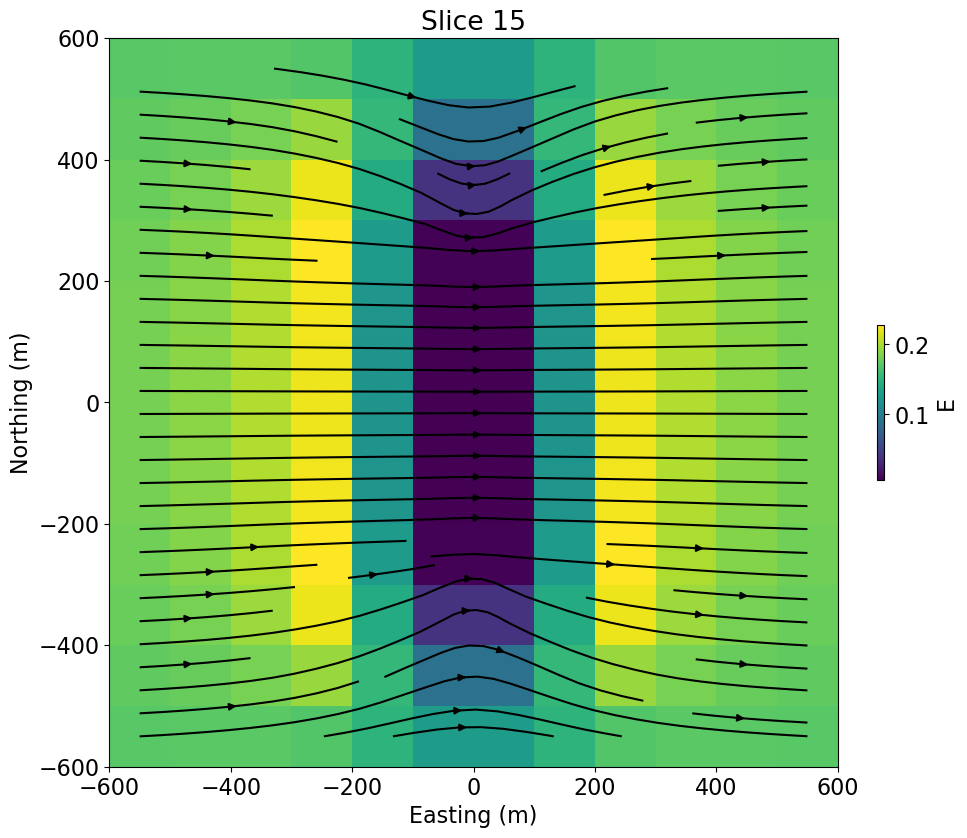

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_slice(e[:,0].real, v_type='E', normal='Z', view='vec', slice_loc=-225, ax=ax, range_x=(-600, 600), range_y=(-600, 600))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("E")
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(-600, 600)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

Text(0, 0.5, 'Northing (m)')

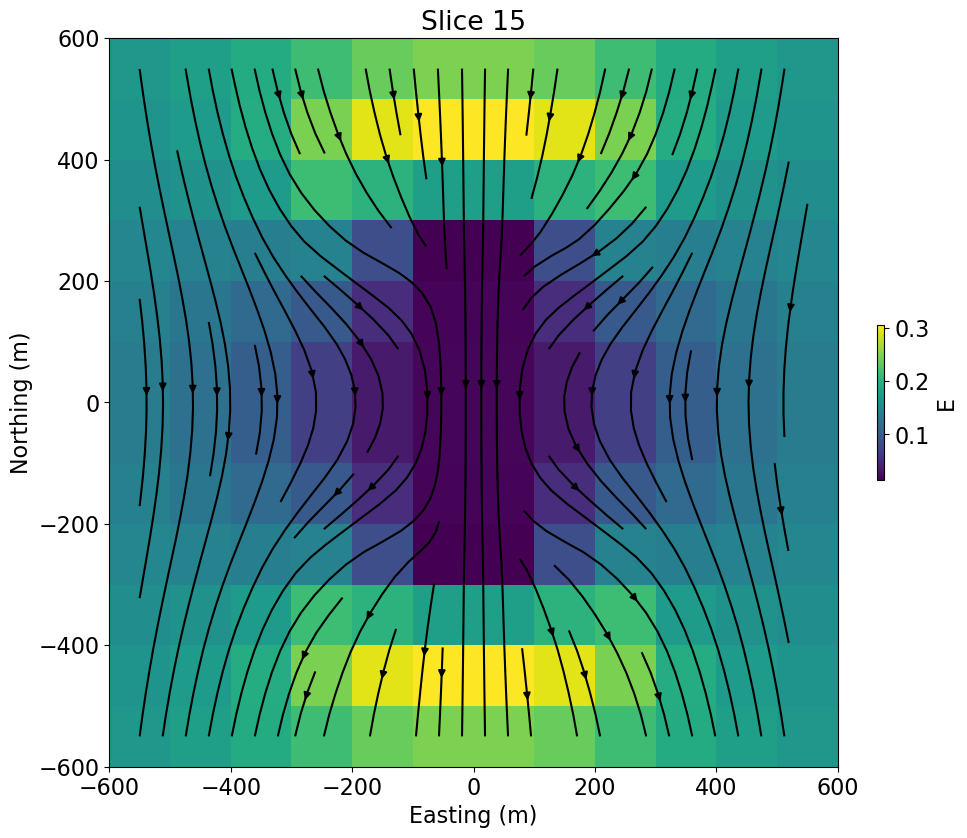

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_slice(e[:,1].real, v_type='E', normal='Z', view='vec', slice_loc=-225, ax=ax, range_x=(-600, 600), range_y=(-600, 600))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("E")
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(-600, 600)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

Text(0, 0.5, 'Northing (m)')

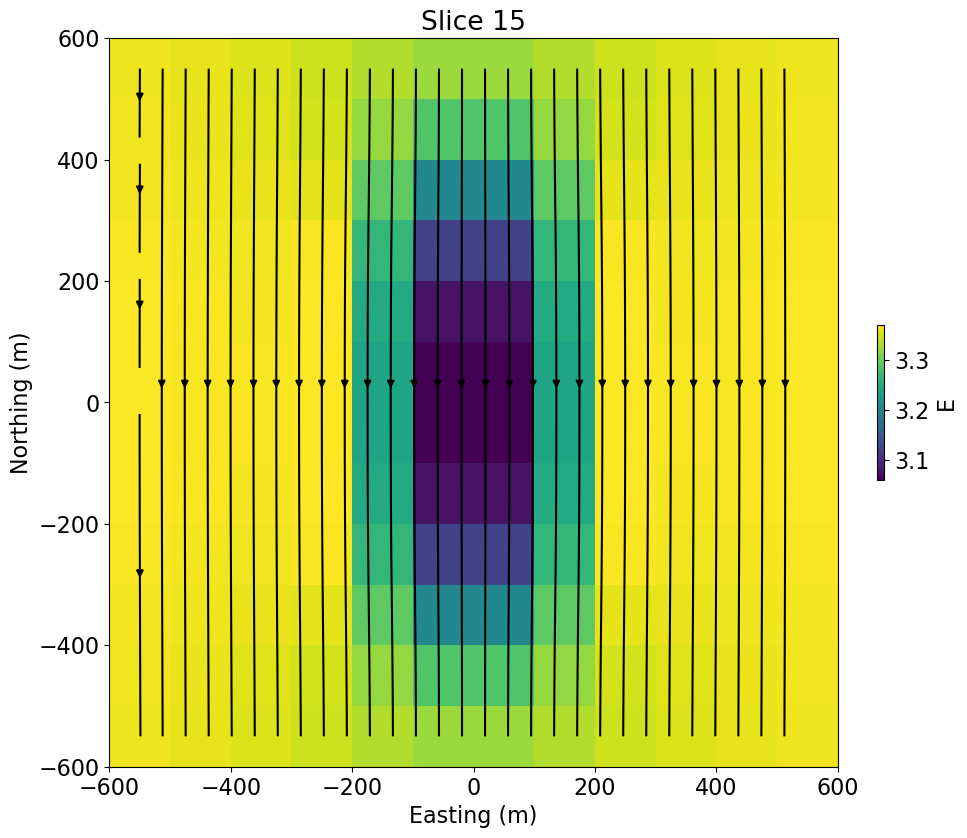

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_slice(h[:,0].real, v_type='F', normal='Z', view='vec', slice_loc=-225, ax=ax, range_x=(-600, 600), range_y=(-600, 600))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("E")
ax.set_aspect(1)
ax.set_ylim(-600, 600)
ax.set_xlim(-600, 600)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

Text(0, 0.5, 'Depth (m)')

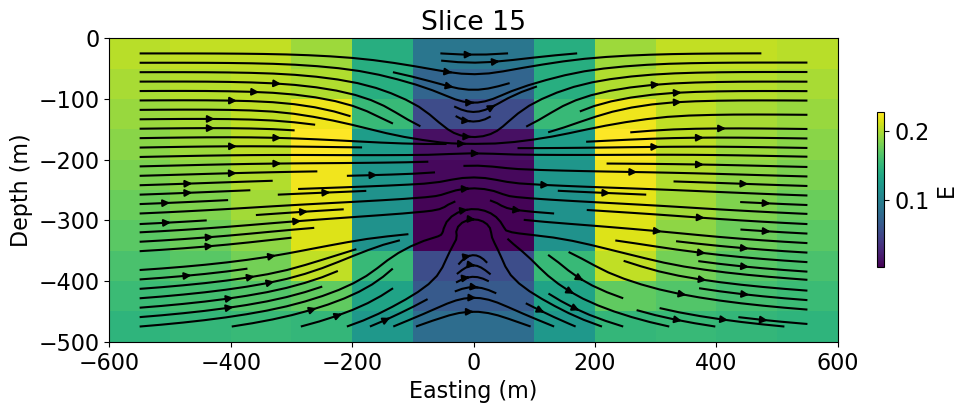

In [59]:
 fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_slice(e[:,0].real, v_type='E', normal='Y', view='vec', slice_loc=0, ax=ax, range_x=(-600, 600), range_y=(-500, 0))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("E")
ax.set_aspect(1)
ax.set_ylim(-500, 0)
ax.set_xlim(-600, 600)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Depth (m)")

Text(0, 0.5, 'Depth (m)')

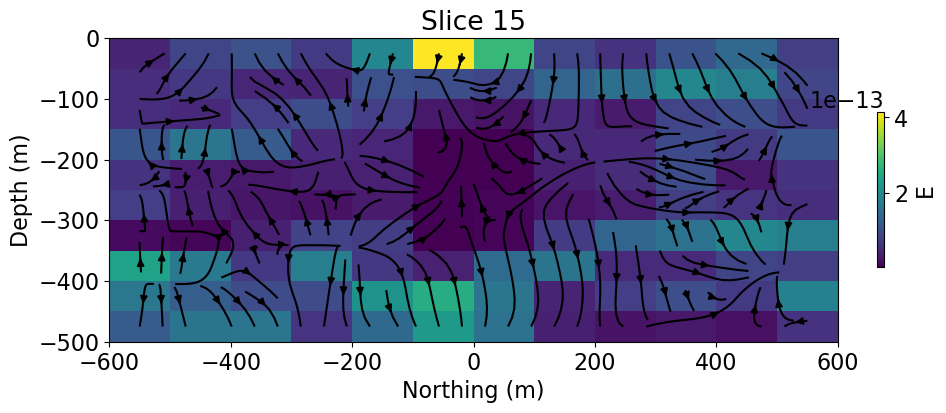

In [67]:
 fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_slice(e[:,1].real, v_type='E', normal='Y', view='vec', slice_loc=0, ax=ax, range_x=(-600, 600), range_y=(-500, 0))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("E")
ax.set_aspect(1)
ax.set_ylim(-500, 0)
ax.set_xlim(-600, 600)
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Depth (m)")

Text(0, 0.5, 'Depth (m)')

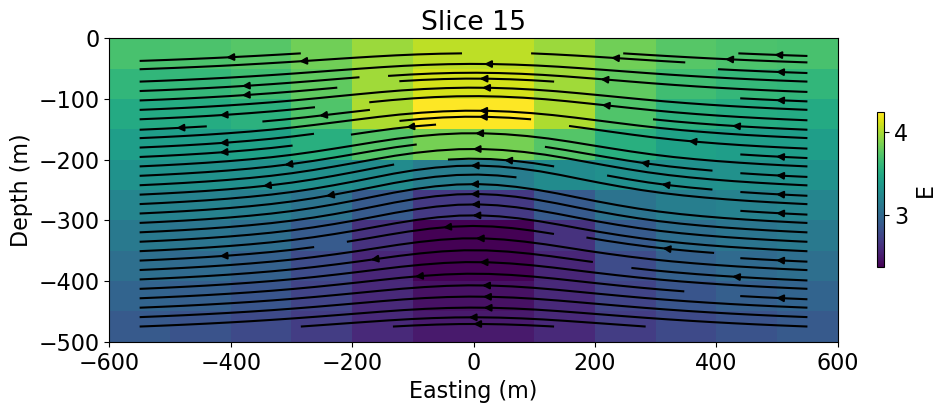

In [64]:
 fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_slice(h[:,1].real, v_type='F', normal='Y', view='vec', slice_loc=0, ax=ax, range_x=(-600, 600), range_y=(-500, 0))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("E")
ax.set_aspect(1)
ax.set_ylim(-500, 0)
ax.set_xlim(-600, 600)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Depth (m)")

Text(0, 0.5, 'Depth (m)')

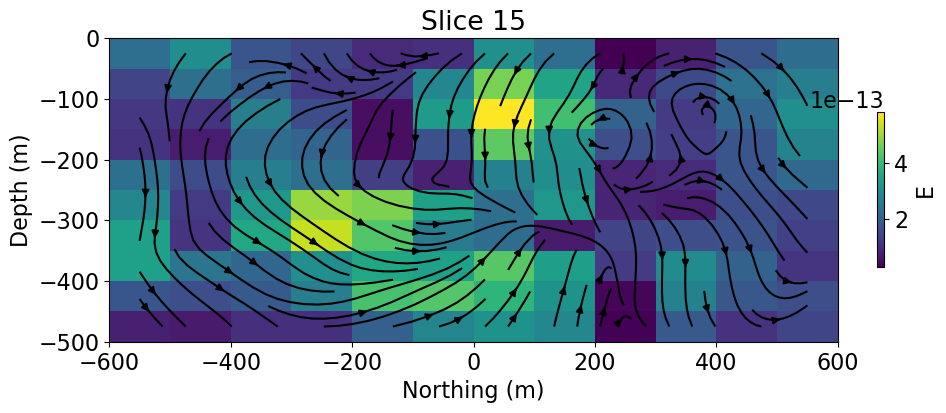

In [66]:
 fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_slice(h[:,1].real, v_type='F', normal='X', view='vec', slice_loc=0, ax=ax, range_x=(-600, 600), range_y=(-500, 0))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("E")
ax.set_aspect(1)
ax.set_ylim(-500, 0)
ax.set_xlim(-600, 600)
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Depth (m)")

In [51]:
mesh.plot_slice??

Signature:
mesh.plot_slice(
    v,
    v_type='CC',
    normal='Z',
    ind=None,
    slice_loc=None,
    grid=False,
    view='real',
    ax=None,
    clim=None,
    show_it=False,
    pcolor_opts=None,
    stream_opts=None,
    grid_opts=None,
    range_x=None,
    range_y=None,
    sample_grid=None,
    stream_threshold=None,
    stream_thickness=None,
    **kwargs,
)
Source:   
    def plot_slice(
        self,
        v,
        v_type="CC",
        normal="Z",
        ind=None,
        slice_loc=None,
        grid=False,
        view="real",
        ax=None,
        clim=None,
        show_it=False,
        pcolor_opts=None,
        stream_opts=None,
        grid_opts=None,
        range_x=None,
        range_y=None,
        sample_grid=None,
        stream_threshold=None,
        stream_thickness=None,
        **kwargs,
    ):
        """Plot a slice of fields on the given 3D mesh.

        Parameters
        ----------
        v : numpy.ndarray
            values to plot
      

# Calculate primary fields

In [37]:
%%time
# Setup the simulation object
simulation_primary = nsem.Simulation3DPrimarySecondary(
    mesh, survey=survey, solver=Solver, sigma=sigBG, sigmaPrimary=sigBG
)

f_primary = simulation_primary.fields()
dpred_primary = simulation_primary.dpred(f=f_primary)

CPU times: user 47.6 s, sys: 983 ms, total: 48.6 s
Wall time: 16.1 s


In [38]:
# # e_primary_test = srcList[0].ePrimary(simulation)
# # print(e_primary_test.shape)
# e_primary = srcList[0].ePrimary(simulation)
# b_primary = srcList[0].bPrimary(simulation)
# h_primary = b_primary/simulation.mu

In [39]:
# Get e and h fields
e_primary = f_primary[srcList[0], 'e']
h_primary = f_primary[srcList[0], 'h']

# print(e_primary.shape)

# Generate interpolation matricies
# Pex = mesh.get_interpolation_matrix(rx_loc, location_type='edges_x')
# Pey = mesh.get_interpolation_matrix(rx_loc, location_type='edges_y')
# Pfx = mesh.get_interpolation_matrix(rx_loc, location_type='faces_x')
# Pfy = mesh.get_interpolation_matrix(rx_loc, location_type='faces_y')
# Pfz = mesh.get_interpolation_matrix(rx_loc, location_type='faces_z')

# Interpolate onto receiver locations
ex_primary = Pex * e_primary
ey_primary = Pey * e_primary
hx_primary = Pfx * h_primary
hy_primary = Pfy * h_primary
hz_primary = Pfz * h_primary

ex_primary_tr = ey_primary.copy()
ey_primary_tr = ex_primary.copy()

hx_primary_tr = hy_primary.copy()
hy_primary_tr = hx_primary.copy()
hz_primary_tr = -hz_primary.copy()

mt_eh_primary_data={
    "Ex_jy": ex_primary_tr[:,0].copy(),
    "Ex_jx": ex_primary_tr[:,1].copy(),
    "Ey_jy": ey_primary_tr[:,0].copy(),
    "Ey_jx": ey_primary_tr[:,1].copy(),
    "Hx_jy": hx_primary_tr[:,0].copy(),
    "Hx_jx": hx_primary_tr[:,1].copy(),
    "Hy_jy": hy_primary_tr[:,0].copy(),
    "Hy_jx": hy_primary_tr[:,1].copy(),
    "Hz_jy": hz_primary_tr[:,0].copy(),
    "Hz_jx": hz_primary_tr[:,1].copy(),
}
names_eh_primary = list(mt_eh_primary_data.keys())

In [40]:
def foo_eh_primary(name):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    out = utils.plot2Ddata(rx_loc[:,:2], mt_eh_primary_data[name].real.flatten(), ax=ax, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    # if(name == 'Ex_jy' or name == 'Ey_jy'):
    #     u_name = 'Ey_jy'
    #     y_stream = np.real(mt_eh_primary_data[u_name])
    #     y_stream[np.abs(y_stream) <= 1e-8] = 0
        
    #     v_name = 'Ex_jy'
    #     x_stream = np.real(mt_eh_primary_data[v_name])
    #     x_stream[np.abs(x_stream) <= 1e-8] = 0
        
    # elif(name == 'Ex_jx' or name == 'Ey_jx'):
    #     u_name = 'Ey_jx'
    #     y_stream = np.real(mt_eh_primary_data[u_name])
    #     y_stream[np.abs(y_stream) <= 1e-6] = 0
        
    #     v_name = 'Ex_jx'
    #     x_stream = np.real(mt_eh_primary_data[v_name])
    #     x_stream[np.abs(x_stream) <= 1e-6] = 0
        
    # elif(name == 'Hx_jy' or name == 'Hy_jy' or name == 'Hz_jy'):
    #     u_name = 'Hy_jy'
    #     y_stream = np.real(mt_eh_primary_data[u_name])
    #     y_stream[np.abs(y_stream) <= 1e-8] = 0
        
    #     v_name = 'Hx_jy'
    #     x_stream = np.real(mt_eh_primary_data[v_name])
    #     x_stream[np.abs(x_stream) <= 1e-8] = 0
        
    # elif(name == 'Hx_jx' or name == 'Hy_jx' or name == 'Hz_jx'):
    #     u_name = 'Hy_jx'
    #     y_stream = np.real(mt_eh_primary_data[u_name])
    #     y_stream[np.abs(y_stream) <= 1e-8] = 0
        
    #     v_name = 'Hx_jx'
    #     x_stream = np.real(mt_eh_primary_data[v_name])
    #     x_stream[np.abs(x_stream) <= 1e-8] = 0

    # plt.streamplot(rx_x, rx_y, np.reshape(y_stream, rx_y.shape), np.reshape(x_stream, rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)
    

    if(name == 'Ex_jy' or name == 'Ey_jy'):
        u_name = 'Ey_jy'
        v_name = 'Ex_jy'
    elif(name == 'Ex_jx' or name == 'Ey_jx'):
        u_name = 'Ey_jx'
        v_name = 'Ex_jx'
    elif(name == 'Hx_jy' or name == 'Hy_jy' or name == 'Hz_jy'):
        u_name = 'Hy_jy'
        v_name = 'Hx_jy'
    elif(name == 'Hx_jx' or name == 'Hy_jx' or name == 'Hz_jx'):
        u_name = 'Hy_jx'
        v_name = 'Hx_jx'

    plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_primary_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_primary_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)

    ax.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out[0], fraction=0.03)
    ax.set_title(str(name + ' (Primary)'))
    ax.set_xlabel('Easting (Y) [m]')
    ax.set_ylabel('Northing (X) [m]')
    ax.set_xlim([-600,600])
    ax.set_ylim([-600,600])

In [41]:
Q_primary = interact(foo_eh_primary, name=widgets.Select(options=names_eh_primary))

interactive(children=(Select(description='name', options=('ex_jy', 'ex_jx', 'ey_jy', 'ey_jx', 'hx_jy', 'hx_jx'…

# Calculate secondary fields

In [42]:
# Get e and h fields
e_secondary = e - e_primary
h_secondary = h - h_primary

# # Generate interpolation matricies
# Pex = mesh.get_interpolation_matrix(rx_loc, location_type='edges_x')
# Pey = mesh.get_interpolation_matrix(rx_loc, location_type='edges_y')
# Pfx = mesh.get_interpolation_matrix(rx_loc, location_type='faces_x')
# Pfy = mesh.get_interpolation_matrix(rx_loc, location_type='faces_y')
# Pfz = mesh.get_interpolation_matrix(rx_loc, location_type='faces_z')

# Interpolate onto receiver locations
ex_secondary = Pex * e_secondary
ey_secondary = Pey * e_secondary
hx_secondary = Pfx * h_secondary
hy_secondary = Pfy * h_secondary
hz_secondary = Pfz * h_secondary

ex_secondary_tr = ey_secondary.copy()
ey_secondary_tr = ex_secondary.copy()

hx_secondary_tr = hy_secondary.copy()
hy_secondary_tr = hx_secondary.copy()
hz_secondary_tr = -hz_secondary.copy()

mt_eh_secondary_data={
    "Ex_jy": ex_secondary_tr[:,0].copy(),
    "Ex_jx": ex_secondary_tr[:,1].copy(),
    "Ey_jy": ey_secondary_tr[:,0].copy(),
    "Ey_jx": ey_secondary_tr[:,1].copy(),
    "Hx_jy": hx_secondary_tr[:,0].copy(),
    "Hx_jx": hx_secondary_tr[:,1].copy(),
    "Hy_jy": hy_secondary_tr[:,0].copy(),
    "Hy_jx": hy_secondary_tr[:,1].copy(),
    "Hz_jy": hz_secondary_tr[:,0].copy(),
    "Hz_jx": hz_secondary_tr[:,1].copy(),
}
names_eh_secondary = list(mt_eh_secondary_data.keys())

In [43]:
def foo_eh_secondary(name):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    out = utils.plot2Ddata(rx_loc[:,:2], mt_eh_secondary_data[name].real.flatten(), ax=ax, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    # if(name == 'Ex_jy' or name == 'Ey_jy'):
    #     u_name = 'Ey_jy'
    #     y_stream = np.real(mt_eh_secondary_data[u_name])
    #     y_stream[np.abs(y_stream) <= 1e-8] = 0
        
    #     v_name = 'Ex_jy'
    #     x_stream = np.real(mt_eh_secondary_data[v_name])
    #     x_stream[np.abs(x_stream) <= 1e-8] = 0
        
    # elif(name == 'Ex_jx' or name == 'Ey_jx'):
    #     u_name = 'Ey_jx'
    #     y_stream = np.real(mt_eh_secondary_data[u_name])
    #     y_stream[np.abs(y_stream) <= 1e-8] = 0
        
    #     v_name = 'Ex_jx'
    #     x_stream = np.real(mt_eh_secondary_data[v_name])
    #     x_stream[np.abs(x_stream) <= 1e-8] = 0
        
    # elif(name == 'Hx_jy' or name == 'Hy_jy' or name == 'Hz_jy'):
    #     u_name = 'Hy_jy'
    #     y_stream = np.real(mt_eh_secondary_data[u_name])
    #     y_stream[np.abs(y_stream) <= 1e-8] = 0
        
    #     v_name = 'Hx_jy'
    #     x_stream = np.real(mt_eh_secondary_data[v_name])
    #     x_stream[np.abs(x_stream) <= 1e-8] = 0
        
    # elif(name == 'Hx_jx' or name == 'Hy_jx' or name == 'Hz_jx'):
    #     u_name = 'Hy_jx'
    #     y_stream = np.real(mt_eh_secondary_data[u_name])
    #     y_stream[np.abs(y_stream) <= 1e-8] = 0
        
    #     v_name = 'Hx_jx'
    #     x_stream = np.real(mt_eh_secondary_data[v_name])
    #     x_stream[np.abs(x_stream) <= 1e-8] = 0
            
    # plt.streamplot(rx_x, rx_y, np.reshape(y_stream, rx_y.shape), np.reshape(x_stream, rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)

    if(name == 'Ex_jy' or name == 'Ey_jy'):
        u_name = 'Ey_jy'
        v_name = 'Ex_jy'
    elif(name == 'Ex_jx' or name == 'Ey_jx'):
        u_name = 'Ey_jx'
        v_name = 'Ex_jx'
    elif(name == 'Hx_jy' or name == 'Hy_jy' or name == 'Hz_jy'):
        u_name = 'Hy_jy'
        v_name = 'Hx_jy'
    elif(name == 'Hx_jx' or name == 'Hy_jx' or name == 'Hz_jx'):
        u_name = 'Hy_jx'
        v_name = 'Hx_jx'

    plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_secondary_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_secondary_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)

    
    ax.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out[0], fraction=0.03)
    ax.set_title(str(name + ' (Secondary)'))
    ax.set_xlabel('Easting (Y) [m]')
    ax.set_ylabel('Northing (X) [m]')
    ax.set_xlim([-600,600])
    ax.set_ylim([-600,600])

In [44]:
Q_secondary = interact(foo_eh_secondary, name=widgets.Select(options=names_eh_secondary))

interactive(children=(Select(description='name', options=('ex_jy', 'ex_jx', 'ey_jy', 'ey_jx', 'hx_jy', 'hx_jx'…

In [45]:
def foo_eh_Primary_Secondary_Total(name):
    fig = plt.figure(figsize=(40, 10))
    ax1 = plt.subplot(1, 3, 1)
    out1 = utils.plot2Ddata(rx_loc[:,:2], mt_eh_primary_data[name].real.flatten(), ax=ax1, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    if(name == 'Ex_jy' or name == 'Ey_jy'):
        u_name = 'Ey_jy'
        v_name = 'Ex_jy'
    elif(name == 'Ex_jx' or name == 'Ey_jx'):
        u_name = 'Ey_jx'
        v_name = 'Ex_jx'
    elif(name == 'Hx_jy' or name == 'Hy_jy' or name == 'Hz_jy'):
        u_name = 'Hy_jy'
        v_name = 'Hx_jy'
    elif(name == 'Hx_jx' or name == 'Hy_jx' or name == 'Hz_jx'):
        u_name = 'Hy_jx'
        v_name = 'Hx_jx'
            
    plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_primary_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_primary_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)

    
    ax1.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out1[0], fraction=0.03)
    ax1.set_title(str(name + ' (Primary)'))
    ax1.set_xlabel('Easting (Y) [m]')
    ax1.set_ylabel('Northing (X) [m]')
    ax1.set_xlim([-600,600])
    ax1.set_ylim([-600,600])
    

    ax2 = plt.subplot(1, 3, 2)
    out2 = utils.plot2Ddata(rx_loc[:,:2], mt_eh_secondary_data[name].real.flatten(), ax=ax2, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    # if(name == 'Ex_jy' or name == 'Ey_jy'):
    #     u_name = 'Ey_jy'
    #     v_name = 'Ex_jy'
    # elif(name == 'Ex_jx' or name == 'Ey_jx'):
    #     u_name = 'Ey_jx'
    #     v_name = 'Ex_jx'
    # elif(name == 'Hx_jy' or name == 'Hy_jy' or name == 'Hz_jy'):
    #     u_name = 'Hy_jy'
    #     v_name = 'Hx_jy'
    # elif(name == 'Hx_jx' or name == 'Hy_jx' or name == 'Hz_jx'):
    #     u_name = 'Hy_jx'
    #     v_name = 'Hx_jx'
            
    plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_secondary_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_secondary_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)

    
    ax2.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out2[0], fraction=0.03)
    ax2.set_title(str(name + ' (Secondary)'))
    ax2.set_xlabel('Easting (Y) [m]')
    ax2.set_ylabel('Northing (X) [m]')
    ax2.set_xlim([-600,600])
    ax2.set_ylim([-600,600])

    
    ax3 = plt.subplot(1, 3, 3)
    out3 = utils.plot2Ddata(rx_loc[:,:2], mt_eh_data[name].real.flatten(), ax=ax3, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    # if(name == 'Ex_jy' or name == 'Ey_jy'):
    #     u_name = 'Ey_jy'
    #     v_name = 'Ex_jy'
    # elif(name == 'Ex_jx' or name == 'Ey_jx'):
    #     u_name = 'Ey_jx'
    #     v_name = 'Ex_jx'
    # elif(name == 'Hx_jy' or name == 'Hy_jy' or name == 'Hz_jy'):
    #     u_name = 'Hy_jy'
    #     v_name = 'Hx_jy'
    # elif(name == 'Hx_jx' or name == 'Hy_jx' or name == 'Hz_jx'):
    #     u_name = 'Hy_jx'
    #     v_name = 'Hx_jx'
            
    plt.streamplot(rx_x, rx_y, np.reshape(np.real(mt_eh_data[u_name]), rx_y.shape), np.reshape(np.real(mt_eh_data[v_name]), rx_x.shape), density=1, linewidth=None, color='k', cmap=None, norm=None, arrowsize=1, arrowstyle='-|>', minlength=0.1, transform=None, zorder=None, start_points=None, maxlength=4.0, integration_direction='both', broken_streamlines=True)

    
    ax3.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out3[0], fraction=0.03)
    ax3.set_title(str(name + ' (Total)'))
    ax3.set_xlabel('Easting (Y) [m]')
    ax3.set_ylabel('Northing (X) [m]')
    ax3.set_xlim([-600,600])
    ax3.set_ylim([-600,600])

In [46]:
Q_Primary_Secondary_Total = interact(foo_eh_Primary_Secondary_Total, name=widgets.Select(options=names_eh))

interactive(children=(Select(description='name', options=('ex_jy', 'ex_jx', 'ey_jy', 'ey_jx', 'hx_jy', 'hx_jx'…